# Text Classification

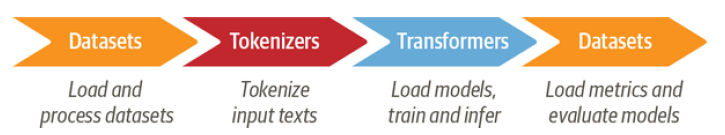

^ Typical hugging face workflow 

# 1. Datasets

In [1]:
from datasets import list_datasets
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 34150 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [2]:
from datasets import load_dataset
emotions = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/fergus/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

so dataset comes in a dictionary, and we can get a specific split with standard python syntax.

This is probably implemented by overwritting the python methods \_\_getitem\_\_ and \_\_setitem\_\_ 

In [4]:
# so dataset comes in 
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
len(train_ds)

16000

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_ds.column_names

['text', 'label']

In [8]:
print(train_ds.features) # gives the data types. 

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [9]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


This shows the standard huggingface data interface. It is based on Apache Arrow which uses a typed columnar format that is more memory efficient than native Python. 

It's easy to get the pandas version of dataframe too

In [10]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


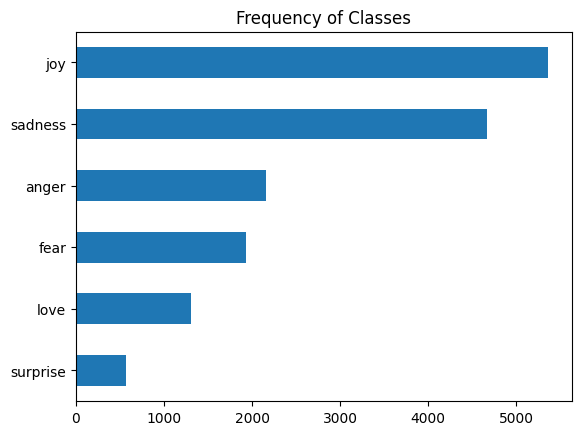

In [12]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

https://imbalanced-learn.org/stable/

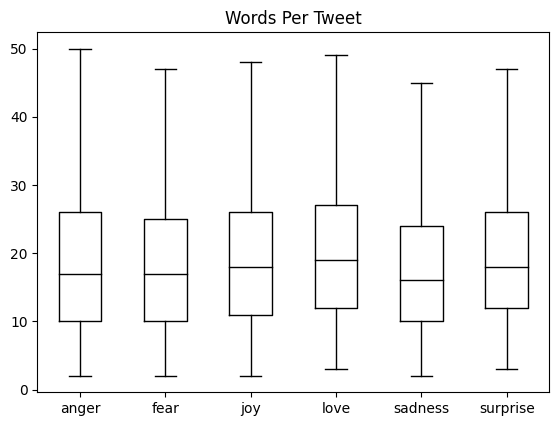

In [13]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [14]:
emotions.reset_format() # stop using dataframe output. 

<br>

# 2. Tokens 

Tokenization = break string down into atomic units used by model. 
e.g. 'I am a dog' -> ['I', 'am', 'a', 'dog']

Begin by looking at character tokenization

In [15]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [16]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [17]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [18]:
# Ohe 
categorical_df = pd.DataFrame(
{"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [19]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [20]:
import torch
import torch.nn.functional as F
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

Now to look at word tokenization:

In [21]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


We want to avoid a large vocab. This means removing anything combinatorial like punctuation included with words, and pre-processing to remove captials, and omitting rare words by using a special token... UNK

Subtokenization is learnt and splits words into chunks. Essentially a combination of character tokenization and word tokenization. An example is WordPiece. 

In [22]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [23]:
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [24]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [25]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [26]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [27]:
tokenizer.vocab_size

30522

In [28]:
tokenizer.model_max_length

512

In [29]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

- padding means that all inputs are of the same size. all smaller than largest will get special padding tokens. 
- truncation removes any tokens beyond maximum context size of model. 

In [30]:
def tokenize(batch):
    print(batch)
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(emotions["train"][:2]))

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'], 'label': [0, 0]}
{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


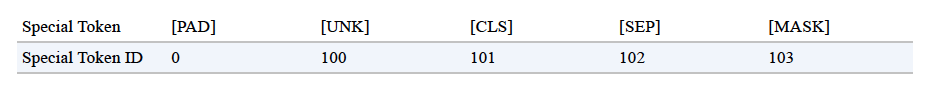

In [31]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None) # map is individually by default. 
print('done')

Loading cached processed dataset at /home/fergus/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-937d7933cb7b1dc7.arrow
Loading cached processed dataset at /home/fergus/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-0013e059b8650ae1.arrow
Loading cached processed dataset at /home/fergus/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-d844159706d13f8e.arrow


done


In [32]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# Training a classifier 

In [35]:
from transformers import AutoModel
device = 'cpu'
model_ckpt = "distilbert-base-uncased"
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


extracting last hidden layer, this is done by setting return_tensors='pt'

In [36]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt") # 
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [40]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


Output is an instance of BaseModelOutput

In [41]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

[batch_size, n_tokens, hidden_dim]

In [43]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]